In [ ]:
"""
OBJETIVO : Analizar los datos de precipitación            
"""
Autor='Diego Paredes'

In [1]:
# Graficos y visualizaciones
import matplotlib.pyplot as plt

# Liberias para manejo de datos
import pandas as pd

# Liberias estandar
import time
import os

In [2]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/NewTesis'

In [4]:
# Realiza un grafico de dispersion (Tipo = 1) o boxplit (Tipo = 2)
def Grafico(df,filename,tipo):    
    x = df.index
    y = df['dato']   
    
    if tipo==1:
        plt.clf()
        plt.scatter(x=x,y=y, alpha=0.1)
    if tipo==2:
        plt.clf()
        plt.boxplot(x=y)
        
    plt.xlabel("Indices")
    plt.ylabel("Precipitacion (mm/h)")
    plt.title(f"{filename.split('/')[-1][:-4]}")
    plt.axhline(y=y.quantile(0.99), color='r', linestyle='-')
    
    plt.savefig(filename)
    plt.clf()
    #plt.show()

    return True

In [5]:
# Crea una carpeta (newDir) en path
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT       
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [6]:
#Por cada estacion se hallara:
#- Cantidad de datos,- Promedio,- Varianza,- Valor min ,- Valor max
#- Fecha minima,- Fecha Maxima,- Cantidad de datos atipicos (Mayores a 99%)
#- Cantidad de NA,- Cantidad de ceros
#- Cantidad de malos, conformes y dudosos
#Graficos
#- Boxplot,- Dispersion

# Si existe listDir, obtendra los datos de precipitacion en esta lista,
# caso contrario usara lo definido en dfDatos
def resumenStats(path_base,estacionesF,dfDatos,year,grafico=0, listDir=''):       
    stations = pd.read_csv(estacionesF)
    
    if listDir:
        listDF = []
        for file in listDir:
            listDF.append(pd.read_csv(file,encoding='latin-1'))
        datos = pd.concat(listDF, ignore_index=True)           
        
    else:
        datos = dfDatos   
        
    start_time = time.time() 
    resultado = []
    
    #Auxiliares    
    total = len(stations.index)
    completados = 1 
    
    path_plot = crearDir(f'{path_base}/Archivos/Reportes/Plots/', year)

    #Por cada estacion se realizara lso graficos
    for i in stations.index:    
        station = stations['ESTACION'][i]
        code = stations['CODE'][i]
        LON = stations['LON'][i]
        LAT = stations['LAT'][i]
        ALT = stations['ALT'][i]

        tempDato = datos.loc[datos['NOMBRE']==station]    
        cantNA = tempDato.loc[tempDato['PRECIPITACION'].isna()].count()[0]

        #Eliminamos todos los NA antes de realizar las estadisticas        
        tempDato = tempDato.dropna(axis='index',subset=['PRECIPITACION'])   
        
        
        cantC02 = tempDato.loc[tempDato['FLAG'].isin(['C0000002'])].count()[0]
        cantC01 = tempDato.loc[tempDato['FLAG'].isin(['C0000001'])].count()[0] 
        cantM01 = tempDato.loc[tempDato['FLAG'].isin(['M0000001','M0000001, M0110302','M0110302'])].count()[0]
        cantM02 = tempDato.loc[tempDato['FLAG'].isin(['M0000002','DIM00001'])].count()[0]
        cantD01 = tempDato.loc[tempDato['FLAG'].isin(['D0220301','D0230301','D0230303'])].count()[0]
        
        #Eliminamos los valores valores mayor a 401 o menor a 0
        tempDato = tempDato[tempDato['PRECIPITACION']<=401]
        tempDato = tempDato[tempDato['PRECIPITACION']>=0]
    
        

        stats = tempDato['PRECIPITACION'].describe()
        stats = stats.to_dict()    
        fmin = tempDato['FECHA'].min()
        fmax = tempDato['FECHA'].max()    
        stats['FechaMax'] = fmax
        stats['count'] = int(stats['count'])
        stats['FechaMin'] = fmin    
        stats['Nombre'] = station
        stats['Codigo'] = code
        stats['ceros'] = tempDato.loc[tempDato['PRECIPITACION']==0].count()[0]
        stats['NA'] = cantNA
        
        stats['cantC02'] = cantC02
        stats['cantC01'] = cantC01
        stats['cantM01'] = cantM01
        stats['cantM02'] = cantM02
        stats['cantD01'] = cantD01
        
        stats['75mayor'] = tempDato.loc[tempDato['PRECIPITACION']>stats['75%']].count()[0]
        stats['90mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.90)].count()[0]
        stats['90%'] =  tempDato['PRECIPITACION'].quantile(0.90)
        stats['99mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.99)].count()[0]
        stats['99%'] =  tempDato['PRECIPITACION'].quantile(0.99)
        stats['LON'] = LON
        stats['LAT'] = LAT
        stats['ALT'] = ALT
        resultado.append(stats)
        
        if grafico:
            Grafico(tempDato,f'{path_plot}/{code}_scatter.png',1)   
            Grafico(tempDato,f'{path_plot}/{code}_box.png',2)   
        
        completados = completados +1
        if not completados % 50:
            progreso = completados/total*100
            f = '{0:.3g}'.format(progreso)
            print(f"Procesando - {f}%")
            

    print("Time taken: %.2fs" % (time.time() - start_time)) 
    
    #Borramos las estaciones que no tengan datos
    df = pd.DataFrame(resultado)
    df = df[df['count']!=0]

    #Guardamso las estadisticas
    df = df.astype({"count":int})
    df.to_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_{year}.csv',index=False)

    return resultado


In [7]:
# Lista de los flags en orden de fase
listaFases = [
    'ND',    'C0000001',    'M0000001',    'M0000001, M0110302' ,    'M0110302',
    'D0210301',    'D0210302',    'D0210303',    'D0210304',    'D0220301',
    'D0230301',    'D0230302',    'D0230303',    'D0230304',    'C0000002',
    'DIM00001',    'M0000002'
]
dfFases = pd.DataFrame({'FLAG' : listaFases})
dfFases = dfFases.reset_index().set_index('FLAG')

In [12]:
# Nombre de los archivos
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'

Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'

df20 = pd.read_csv(Fdatos2020,encoding='latin-1')
df21 = pd.read_csv(Fdatos2021,encoding='latin-1')

# Unimos los dos años de precipitaciones en un solo DataFrame
dfPrecipitacion = pd.concat([df20,df21], ignore_index=True) 

In [14]:
#Revisamos la cantidad de datos por flag
dfFlag = dfPrecipitacion.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
dfFlag['Fase'] = dfFlag['FLAG'].map(dfFases['index'])
dfFlag = dfFlag.sort_values(by=['Fase'])
dfFlag['porc%'] = dfFlag['Cantidad'] / dfFlag['Cantidad'].sum() * 100

dfFlag

,FLAG,Cantidad,Fase,porc%
10,ND,462645,0,13.272817
0,C0000001,2877873,1,82.563264
6,M0000001,17,2,0.000488
7,"M0000001, M0110302",5646,3,0.161978
9,M0110302,554,4,0.015894
2,D0220301,24744,9,0.709880
3,D0230301,21440,10,0.615092
4,D0230303,25826,12,0.740922
1,C0000002,58364,14,1.674404
5,DIM00001,2,15,0.000057


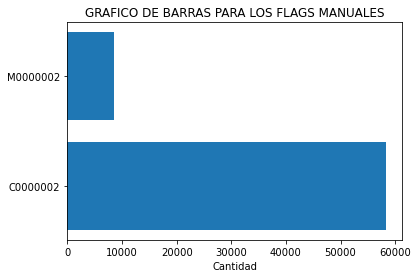

,FLAG,Cantidad,Fase,porc%
1,C0000002,58364,14,1.674404
8,M0000002,8547,16,0.245205


In [15]:
# Eliminar malos en Etapa 1 ( orden de "listaFases")
eliminarFG = [0,1,2,3,4,9,10,12,15]
dfFlagManual = dfFlag[~dfFlag['Fase'].isin(eliminarFG)]

fig, ax = plt.subplots()
ax.barh(dfFlagManual['FLAG'], dfFlagManual['Cantidad'])
plt.xlabel('Cantidad')
plt.title('GRAFICO DE BARRAS PARA LOS FLAGS MANUALES')
plt.show()

dfFlagManual

Total       : 8547
Cantidad M01: 173


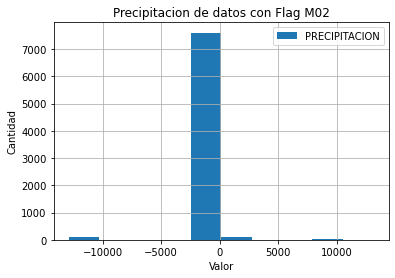

In [16]:
# Analizamos los datos M02
dfPrecipitacion[dfPrecipitacion['FLAG']=='M0000002']['PRECIPITACION'].hist(legend=True)
print(f"Total       : {len(dfPrecipitacion[dfPrecipitacion['FLAG']=='M0000002'])}")
print(f"Cantidad M01: {len(dfPrecipitacion[(dfPrecipitacion['FLAG']=='M0000002') & ((dfPrecipitacion['PRECIPITACION']>401) | (dfPrecipitacion['PRECIPITACION']<0))])}")
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Precipitacion de datos con Flag M02')
plt.show()

Total       : 58364
Cantidad M01: 64


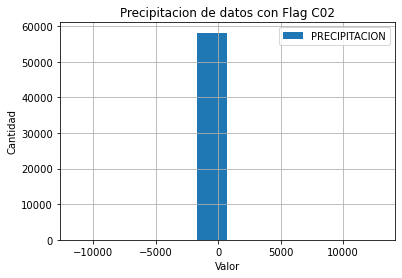

In [17]:
# Analizamos los datos C02
dfPrecipitacion[dfPrecipitacion['FLAG']=='C0000002']['PRECIPITACION'].hist(legend=True)
print(f"Total       : {len(dfPrecipitacion[dfPrecipitacion['FLAG']=='C0000002'])}")
print(f"Cantidad M01: {len(dfPrecipitacion[(dfPrecipitacion['FLAG']=='C0000002') & ((dfPrecipitacion['PRECIPITACION']>401) | (dfPrecipitacion['PRECIPITACION']<0))])}")
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Precipitacion de datos con Flag C02')
plt.show()

In [18]:
# Visualizamos lso datos M01 en C02
dfPrecipitacion[(dfPrecipitacion['FLAG']=='C0000002') & (dfPrecipitacion['PRECIPITACION']<0)]

,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG
1389039,472A218A,ANTONIO RAIMONDI,09/04/2021,13:00:00,-11233.1,C0000002
1436351,472501F4,BALSAS,03/12/2021,23:00:00,-3535.6,C0000002
1497619,109096,BUENA VISTA,20/10/2021,22:00:00,-999.0,C0000002
1506570,4727547C,CABALLOCOCHA,28/10/2021,21:00:00,-11080.1,C0000002
1632525,113249,CAÑETE,13/10/2021,21:00:00,-999.0,C0000002
...,...,...,...,...,...,...
3201944,109091,SAUCEPAMPA,13/10/2021,22:00:00,-999.0,C0000002
3319576,47E2D1CC,TARATA,13/04/2021,23:00:00,-999.0,C0000002
3427067,472D60B4,USQUIL,07/11/2021,20:00:00,-4271.6,C0000002
3427283,472D60B4,USQUIL,16/11/2021,20:00:00,-999.0,C0000002


In [11]:
#Realizaremos un resumen de los datos año 2020
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

#resultados = resumenStats(path_base,Festaciones,dfPrecipitacion,'Total',grafico)
dfAnalisis = pd.read_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_Total.csv')
dfAnalisis

,count,mean,std,min,25%,50%,75%,max,FechaMax,FechaMin,...,cantM02,cantD01,75mayor,90mayor,90%,99mayor,99%,LON,LAT,ALT
0,15298,0.045169,1.962420,0.0,0.0,0.0,0.0,234.0,31/12/2021,01/01/2021,...,0,79,330,330,0.0,144,0.300,-80.39788,-4.48047,116.0
1,9123,0.046092,0.664392,0.0,0.0,0.0,0.0,36.0,31/12/2021,01/01/2021,...,0,123,240,240,0.0,90,0.600,-80.39014,-4.48956,116.0
2,15291,0.129795,0.940547,0.0,0.0,0.0,0.0,34.6,31/12/2021,01/01/2021,...,2,425,1828,1030,0.1,152,3.300,-79.71077,-4.63776,2633.0
3,15281,0.014273,0.251701,0.0,0.0,0.0,0.0,20.3,31/12/2021,01/01/2021,...,0,225,350,350,0.0,135,0.200,-80.42964,-3.55117,12.0
4,7278,0.062242,0.502426,0.0,0.0,0.0,0.0,20.8,31/12/2020,01/01/2021,...,0,349,658,658,0.0,72,1.400,-79.60535,-5.40058,1270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,7584,0.129562,2.755441,0.0,0.0,0.0,0.0,234.0,31/12/2021,01/03/2021,...,0,221,734,734,0.0,70,2.700,-71.01823,-13.92214,4869.0
197,15289,0.129511,0.763248,0.0,0.0,0.0,0.0,23.8,31/12/2021,01/01/2021,...,0,558,1525,1525,0.0,150,3.400,-73.68839,-13.63369,3324.0
198,2286,0.248250,1.064121,0.0,0.0,0.0,0.0,17.9,31/12/2021,01/10/2021,...,0,118,422,218,0.4,22,4.900,-77.90148,-7.91230,2898.0
199,7525,0.111269,0.556543,0.0,0.0,0.0,0.0,8.7,31/12/2021,01/03/2021,...,0,189,802,595,0.1,76,3.076,-70.08281,-13.88492,3873.0


In [3]:
"""
---------------------------------------------------------
LUEGO DE REALIZAR LA SIMULACION DE CONTROL DE CALIDAD ...
---------------------------------------------------------

"""
fileV2 = f'{path_base}/Archivos/Dataset/dsFLAGV2.csv'

In [20]:
# Visualizamos
dsCompleto =pd.read_csv(fileV2)
dsCompleto.head(5)

,Unnamed: 0,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG,FLAGV2
0,0,4722A338,ACJANACO,01/01/2021,00:00:00,0.1,C0000001,C01
1,1,4722A338,ACJANACO,01/01/2021,01:00:00,0.0,C0000001,C01
2,2,4722A338,ACJANACO,01/01/2021,02:00:00,0.0,C0000001,C01
3,3,4722A338,ACJANACO,01/01/2021,03:00:00,0.0,C0000001,C01
4,4,4722A338,ACJANACO,01/01/2021,04:00:00,0.0,C0000001,C01


In [80]:
# Seleccionamos solo lso que vamos a usar (C02 y M02)
dsC02_V2 = dsCompleto[dsCompleto['FLAG']=='C0000002']
dsM02_V2 = dsCompleto[dsCompleto['FLAG']=='M0000002']

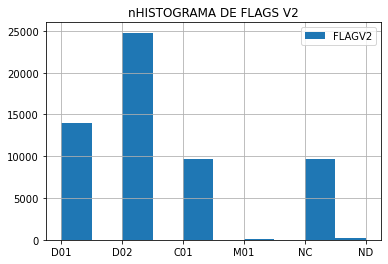

FLAGV2 para datos CONFORME MANUAL (C02)


,FLAGV2,Cantidad,porc%
0,C01,9630,16.499897
1,D01,14003,23.992530
2,D02,24790,42.474813
3,M01,64,0.109657
4,NC,9711,16.638681
5,ND,166,0.284422


In [83]:
#Revisamos la cantidad de datos por flag
dfC2_FlagV2 = dsC02_V2.groupby(['FLAGV2'], dropna = False).size().reset_index(name='Cantidad')
dfC2_FlagV2['porc%'] = dfC2_FlagV2['Cantidad'] / dfC2_FlagV2['Cantidad'].sum() * 100


dsC02_V2['FLAGV2'].hist(legend=True)
plt.title('nHISTOGRAMA DE FLAGS V2')
plt.show()

print('FLAGV2 para datos CONFORME MANUAL (C02)')
dfC2_FlagV2

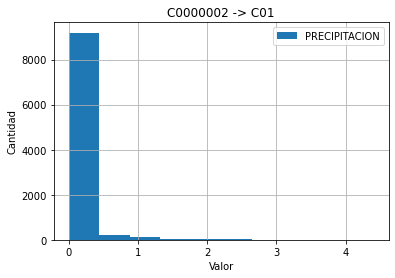

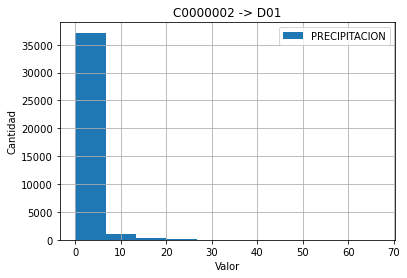

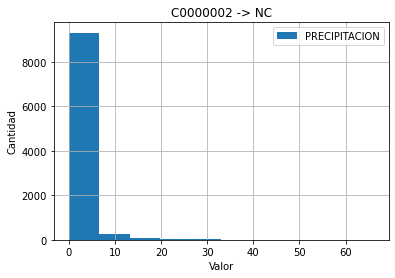

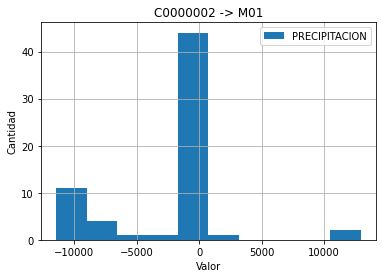

In [99]:
# Analizamos flag V2 para C02
dsC02_C01 = dsC02_V2[(dsC02_V2['FLAGV2']=='C01')]
dsC02_C01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> C01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

dsC02_D01 = dsC02_V2[(dsC02_V2['FLAGV2'].isin(['D01','D02']))]
dsC02_D01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> D01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsC02_NC = dsC02_V2[(dsC02_V2['FLAGV2']=='NC')]
dsC02_NC['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> NC')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsC02_M01 = dsC02_V2[(dsC02_V2['FLAGV2']=='M01')]
dsC02_M01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> M01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

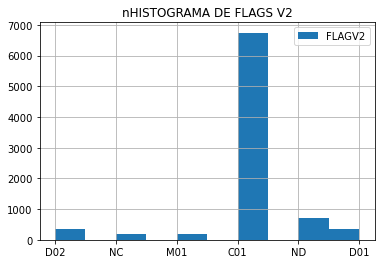

FLAGV2 para datos CONFORME MANUAL (M02)


,FLAGV2,Cantidad,porc%
0,C01,6745,78.916579
1,D01,357,4.176904
2,D02,366,4.282204
3,M01,173,2.024102
4,NC,204,2.386802
5,ND,702,8.213408


In [100]:
#Revisamos la cantidad de datos por flag
dfM2_FlagV2 = dsM02_V2.groupby(['FLAGV2'], dropna = False).size().reset_index(name='Cantidad')
dfM2_FlagV2['porc%'] = dfM2_FlagV2['Cantidad'] / dfM2_FlagV2['Cantidad'].sum() * 100


dsM02_V2['FLAGV2'].hist(legend=True)
plt.title('nHISTOGRAMA DE FLAGS V2')
plt.show()

print('FLAGV2 para datos CONFORME MANUAL (M02)')
dfM2_FlagV2

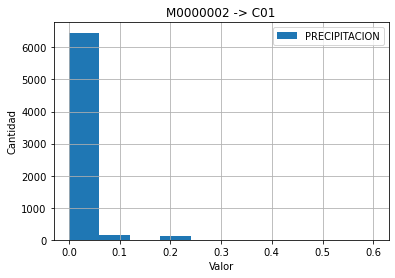

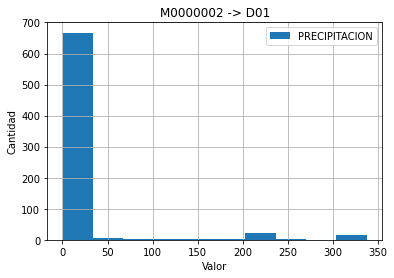

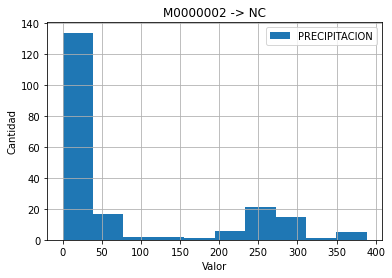

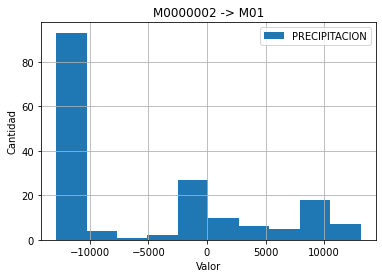

In [98]:
# Analizamos flag V2 para M02
dsM02_C01 = dsM02_V2[(dsM02_V2['FLAGV2']=='C01')]
dsM02_C01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> C01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

dsM02_D01 = dsM02_V2[(dsM02_V2['FLAGV2'].isin(['D01','D02']))]
dsM02_D01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> D01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsM02_NC = dsM02_V2[(dsM02_V2['FLAGV2']=='NC')]
dsM02_NC['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> NC')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsM02_M01 = dsM02_V2[(dsM02_V2['FLAGV2']=='M01')]
dsM02_M01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> M01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()